# Multitask GP Regression using pymc
Source: https://docs.gpytorch.ai/en/latest/examples/03_Multitask_Exact_GPs/Multitask_GP_Regression.html

In [31]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
# set the seed
np.random.seed(1)
from multi_ouputs import build_XY, ICM, LCM, MultiMarginal

In [32]:
import math
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up training data

In [33]:
train_x = np.linspace(0, 1, 18)

train_y = np.stack([
    np.sin(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (2 * math.pi)) + np.random.randn(len(train_x)) * 0.2,
    np.cos(train_x * (1 * math.pi)) + np.random.randn(len(train_x)) * 0.1,
], -1)

In [34]:
train_x.shape, train_y.shape

((18,), (18, 3))

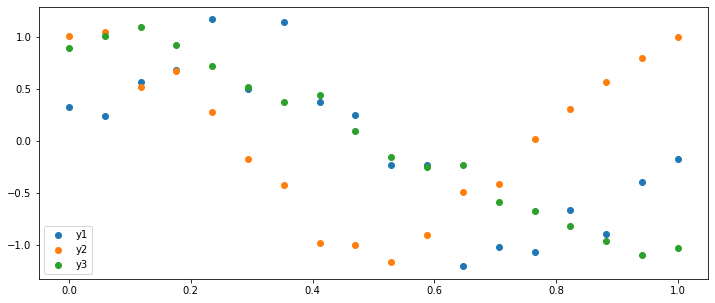

In [35]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
ax.scatter(train_x, train_y[:,0])
ax.scatter(train_x, train_y[:,1])
ax.scatter(train_x, train_y[:,2])
plt.legend(["y1", "y2", "y3"])

In [36]:
train_x.shape, train_y.shape

((18,), (18, 3))

In [37]:
np.vstack([train_y[:,0], train_y[:,1], train_y[:,2]]).shape

(3, 18)

In [38]:
x = train_x.reshape(-1,1)
X, Y, _ = build_XY([x,x,x], 
                   [train_y[:,0].reshape(-1,1), 
                    train_y[:,1].reshape(-1,1), 
                    train_y[:,2].reshape(-1,1)])
x.shape, X.shape, Y.shape

((18, 1), (54, 2), (54, 1))

In [39]:
n_points = 200
x_new = np.linspace(-0.5, 1.5, n_points)[:, None]
X_new, _, _ = build_XY([x_new, x_new, x_new])

In [40]:
X_new.shape

(600, 2)

### LCM

In [41]:
# OPTION 1
# with pm.Model() as model:
#     # Priors
#     ell = pm.Gamma("ell", alpha=2, beta=0.5, shape=2)
#     eta = pm.Gamma("eta", alpha=2, beta=0.5, shape=2)
#     kernels = [pm.gp.cov.ExpQuad, pm.gp.cov.Matern32]
#     sigma = pm.HalfNormal("sigma", sigma=3)
    
#     # Define a list of covariance functions
#     cov_list = [eta[idx] ** 2 * kernel(2,ls=ell[idx], active_dims=[0]) 
#                 for idx, kernel in zip(range(2), kernels)]
    
#     # Define a LCM model
#     lcm = LCM(input_dim=2, active_dims=[1], num_outputs=3, kernel_list=cov_list)
    
#     # Using the existing gp.Marginal
#     gp = pm.gp.Marginal(cov_func=lcm())
#     y_ = gp.marginal_likelihood("f", X, Y, noise=sigma)

In [ ]:
# OPTION 2
with pm.Model() as model:
    # Priors
    ell = pm.Gamma("ell", alpha=2, beta=0.5, shape=2)
    eta = pm.Gamma("eta", alpha=2, beta=0.5, shape=2)
    kernels = [pm.gp.cov.ExpQuad, pm.gp.cov.Matern32]
    sigma = pm.HalfNormal("sigma", sigma=3)
    
    # Define a list of covariance functions
    cov_list = [eta[idx] ** 2 * kernel(2,ls=ell[idx], active_dims=[0]) 
                for idx, kernel in zip(range(2), kernels)]
    
    # Define a LCM model
    # TODO: Figure out to impute input_dim, activate_dims, ...
    lcm = gov.cov.MultiOutput(name="icm", kernels=cov_list) 
    
    # Using the existing gp.Marginal
    gp = pm.gp.Marginal(cov_func=lcm())
    y_ = gp.marginal_likelihood("f", X, Y, noise=sigma)

In [42]:
vars(mogp)

{'mean_list': 0,
 'cov_list': [<pymc.gp.cov.Prod at 0x7f4e9270eb50>,
 'cov_func': None,
 'mean_func': <pymc.gp.mean.Zero at 0x7f4e6bf51dc0>}

In [45]:
# OPTION 3
with pm.Model() as model:
    # Priors
    ell = pm.Gamma("ell", alpha=2, beta=0.5, shape=2)
    eta = pm.Gamma("eta", alpha=2, beta=0.5, shape=2)
    kernels = [pm.gp.cov.ExpQuad, pm.gp.cov.Matern32]
    sigma = pm.HalfNormal("sigma", sigma=3)
    
    # Define a list of covariance functions
    cov_list = [eta[idx] ** 2 * kernel(2,ls=ell[idx], active_dims=[0]) 
                for idx, kernel in zip(range(2), kernels)]
    
    # Define a Multi-output GP using `lcm` or `icm` coregion
    mogp = MultiMarginal(mean_list=0, cov_list=cov_list, type='lcm')    
    y_ = mogp.marginal_likelihood("f", X, Y.squeeze(), noise=sigma)    

In [46]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, sigma, ICM_0_W, ICM_0_kappa, ICM_1_W, ICM_1_kappa]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 38 seconds.


CPU times: user 1min 41s, sys: 3min 27s, total: 5min 8s
Wall time: 45.5 s


In [47]:
with model:
    preds = mogp.conditional("preds", X_new)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'], random_seed=42)

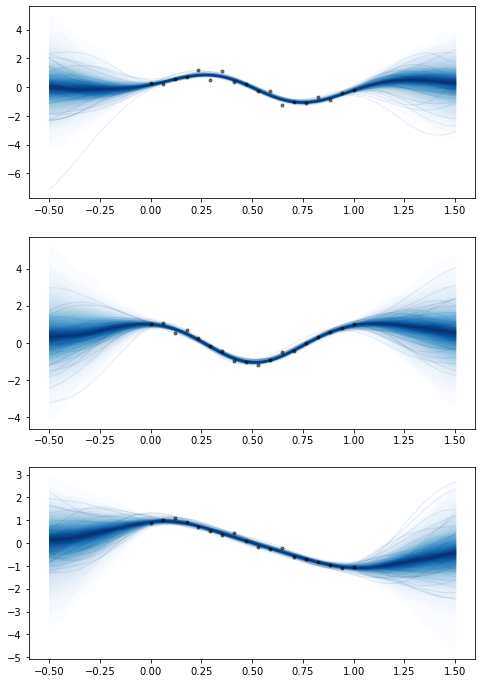

In [48]:
from pymc.gp.util import plot_gp_dist

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
fig, axes = plt.subplots(3,1, figsize=(8,12))

for idx in range(3):
    plot_gp_dist(axes[idx], f_pred[:,n_points*idx:n_points*(idx+1)], 
                 X_new[n_points*idx:n_points*(idx+1),0], 
                 palette="Blues", fill_alpha=0.5, samples_alpha=0.1)
    axes[idx].plot(x, train_y[:,idx], 'ok', ms=3, alpha=0.5, label="Data 1");

In [49]:
az.summary(gp_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"ICM_0_W[0, 0]",0.294,3.125,-6.288,5.704,0.151,0.158,434.0,227.0,NaN
"ICM_0_W[1, 0]",0.055,3.001,-5.244,5.758,0.179,0.152,322.0,305.0,NaN
"ICM_0_W[2, 0]",-0.110,1.872,-3.684,3.265,0.083,0.073,548.0,291.0,NaN
"ICM_1_W[0, 0]",-0.066,4.363,-7.830,8.289,0.176,0.190,603.0,313.0,NaN
"ICM_1_W[1, 0]",-0.358,4.377,-9.050,7.591,0.204,0.226,453.0,295.0,NaN
"ICM_1_W[2, 0]",-0.045,4.516,-7.605,8.399,0.199,0.199,521.0,397.0,NaN
ell[0],0.323,0.054,0.233,0.422,0.003,0.002,353.0,242.0,NaN
ell[1],4.552,2.902,0.501,9.726,0.115,0.088,650.0,387.0,NaN
eta[0],0.475,0.200,0.207,0.770,0.013,0.009,294.0,238.0,NaN
eta[1],0.412,0.411,0.031,1.009,0.019,0.015,355.0,187.0,NaN


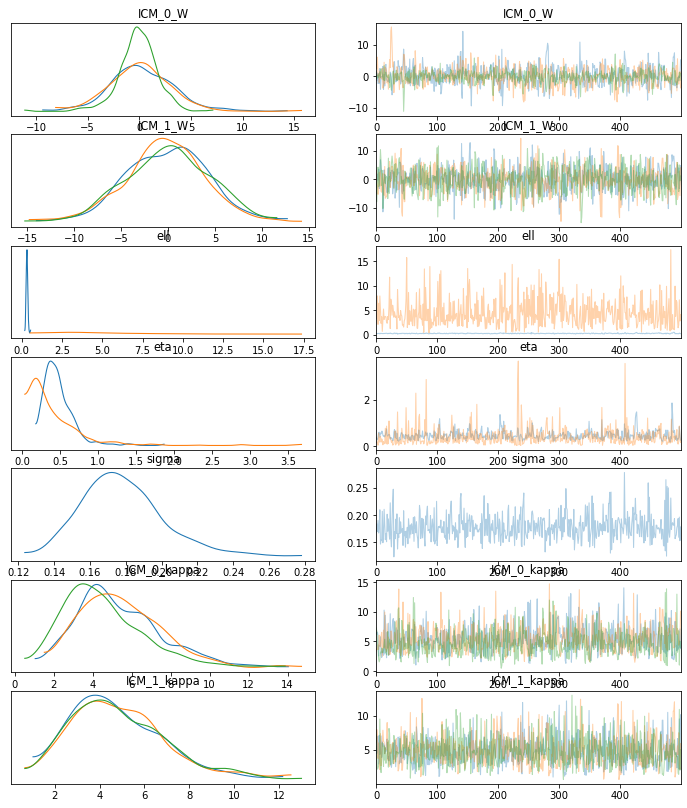

In [50]:
az.plot_trace(gp_trace);